
Running Monte Carlo simulations for Linear DGP...
Processing sample size n = 50


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:30<00:00, 32.85it/s]


Processing sample size n = 100


100%|██████████| 1000/1000 [00:29<00:00, 33.50it/s]


Processing sample size n = 200


100%|██████████| 1000/1000 [00:27<00:00, 36.01it/s]


Processing sample size n = 500


100%|██████████| 1000/1000 [00:28<00:00, 35.32it/s]


Processing sample size n = 1000


100%|██████████| 1000/1000 [00:30<00:00, 33.04it/s]



Analysis of results:

Optimal λ values by sample size:
n = 50: λ = 1.519911
n = 100: λ = 1.519911
n = 200: λ = 1.072267
n = 500: λ = 0.001000
n = 1000: λ = 0.001000

Simulation complete. Check the generated plots for visualizations.


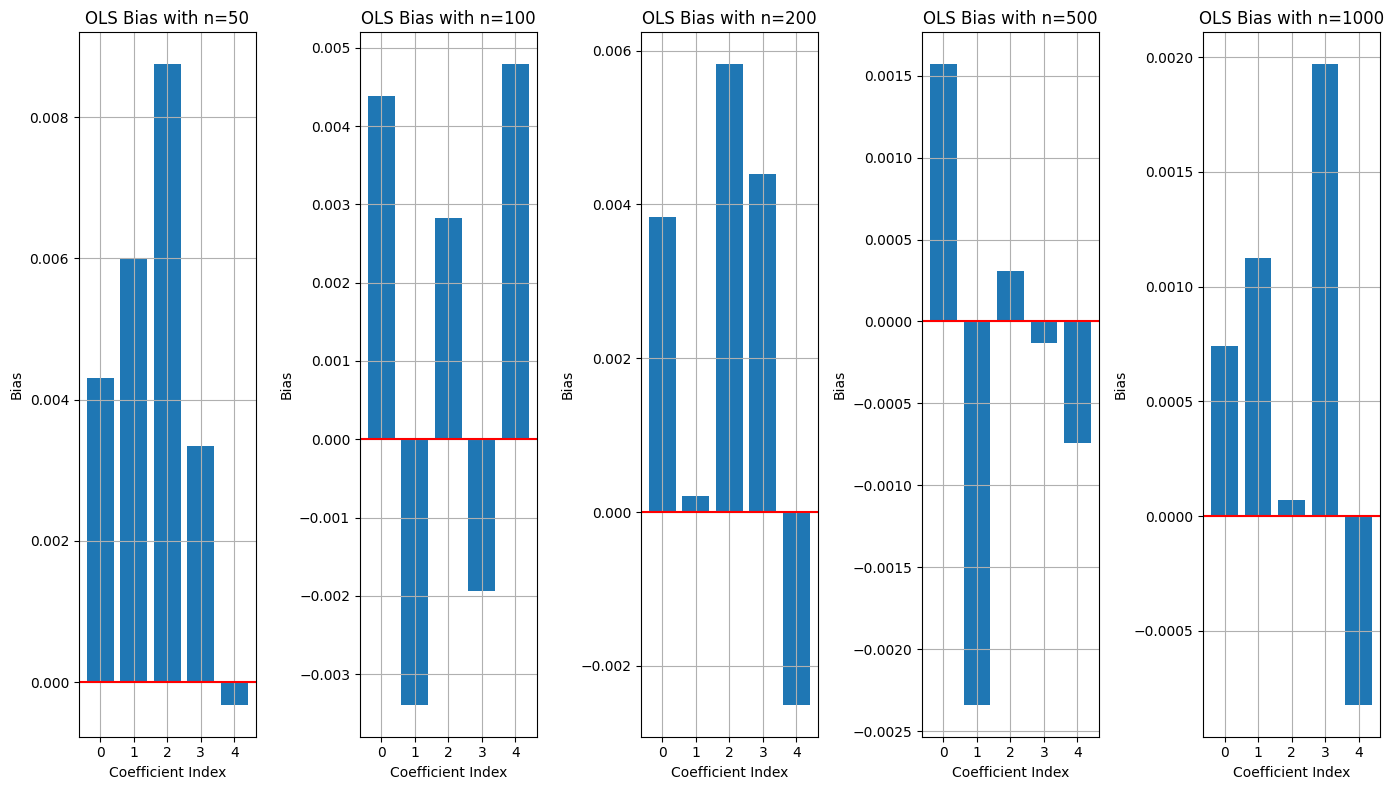

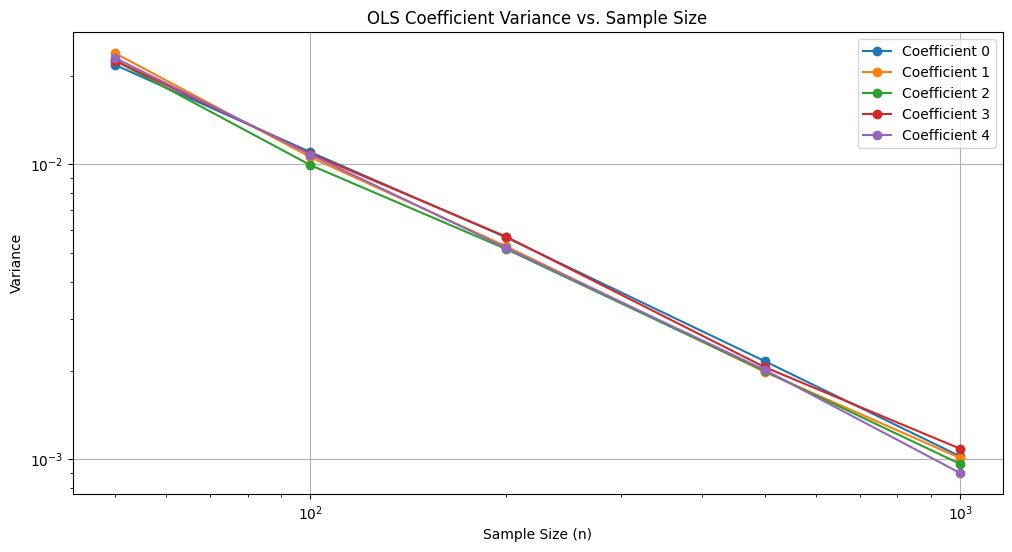

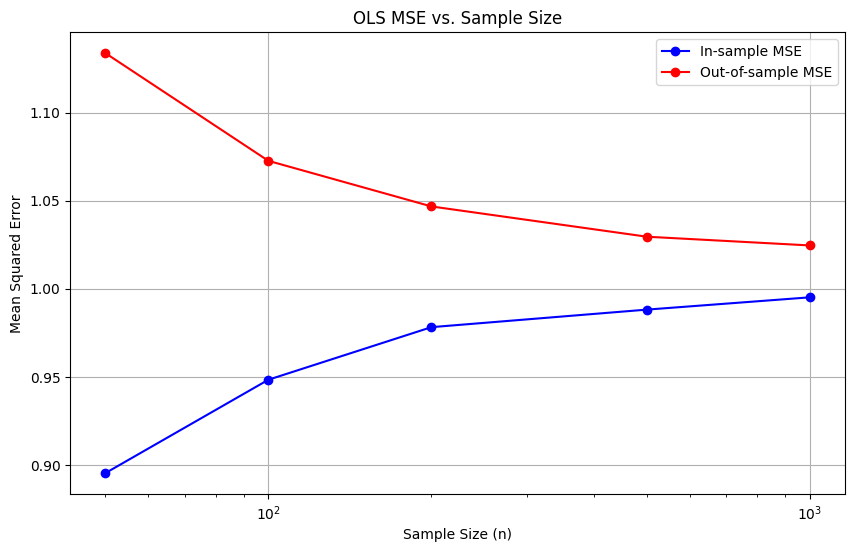

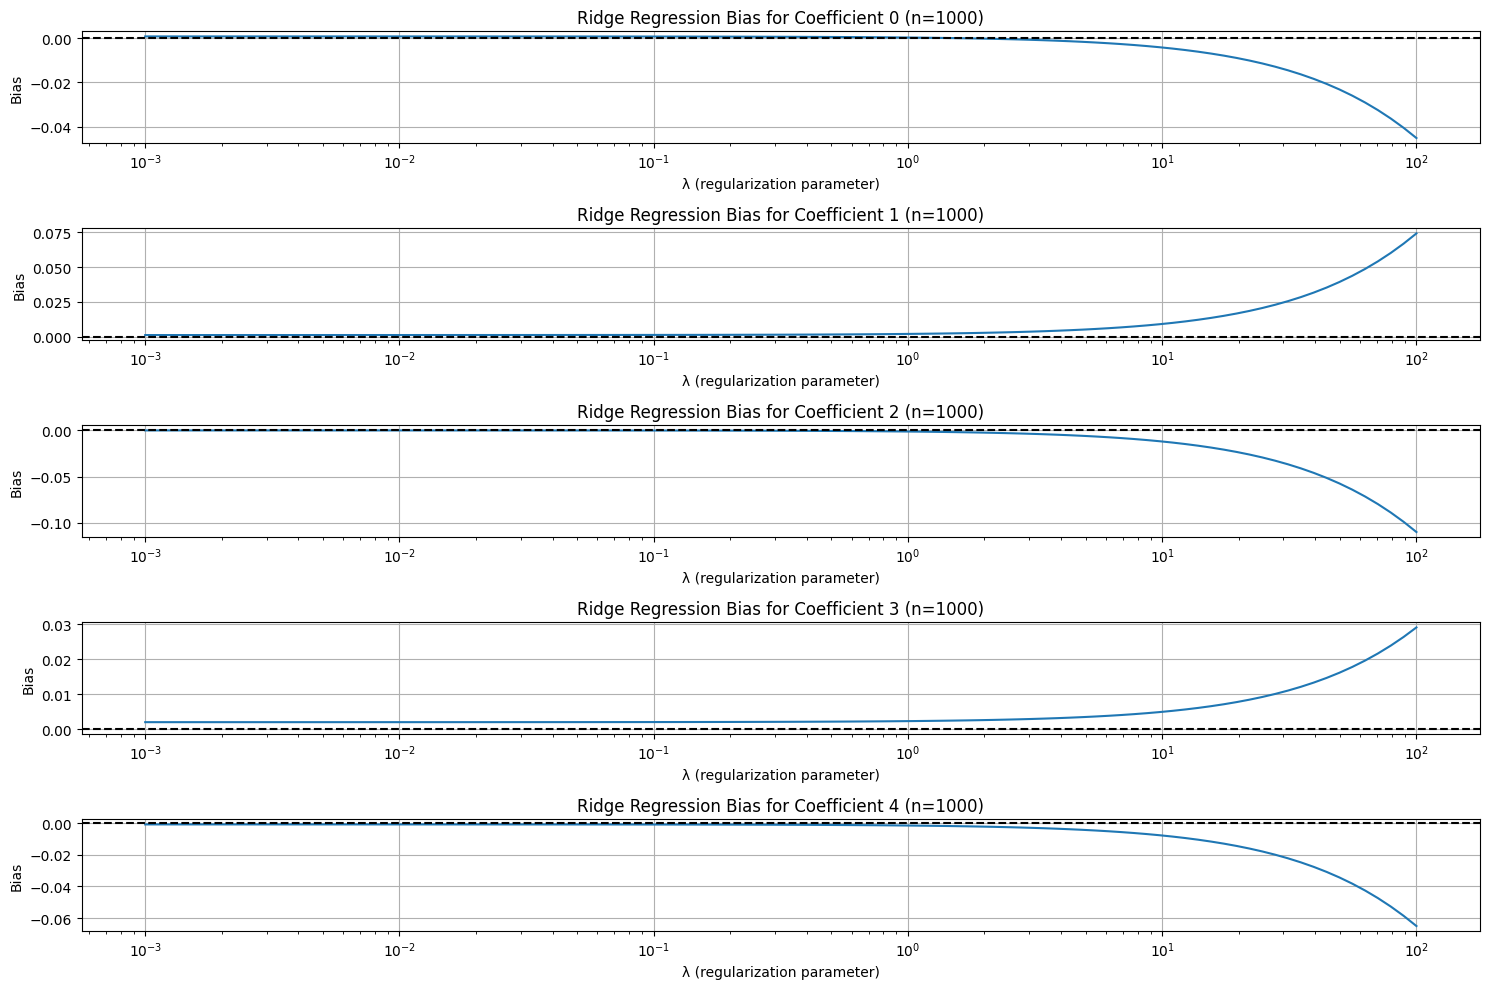

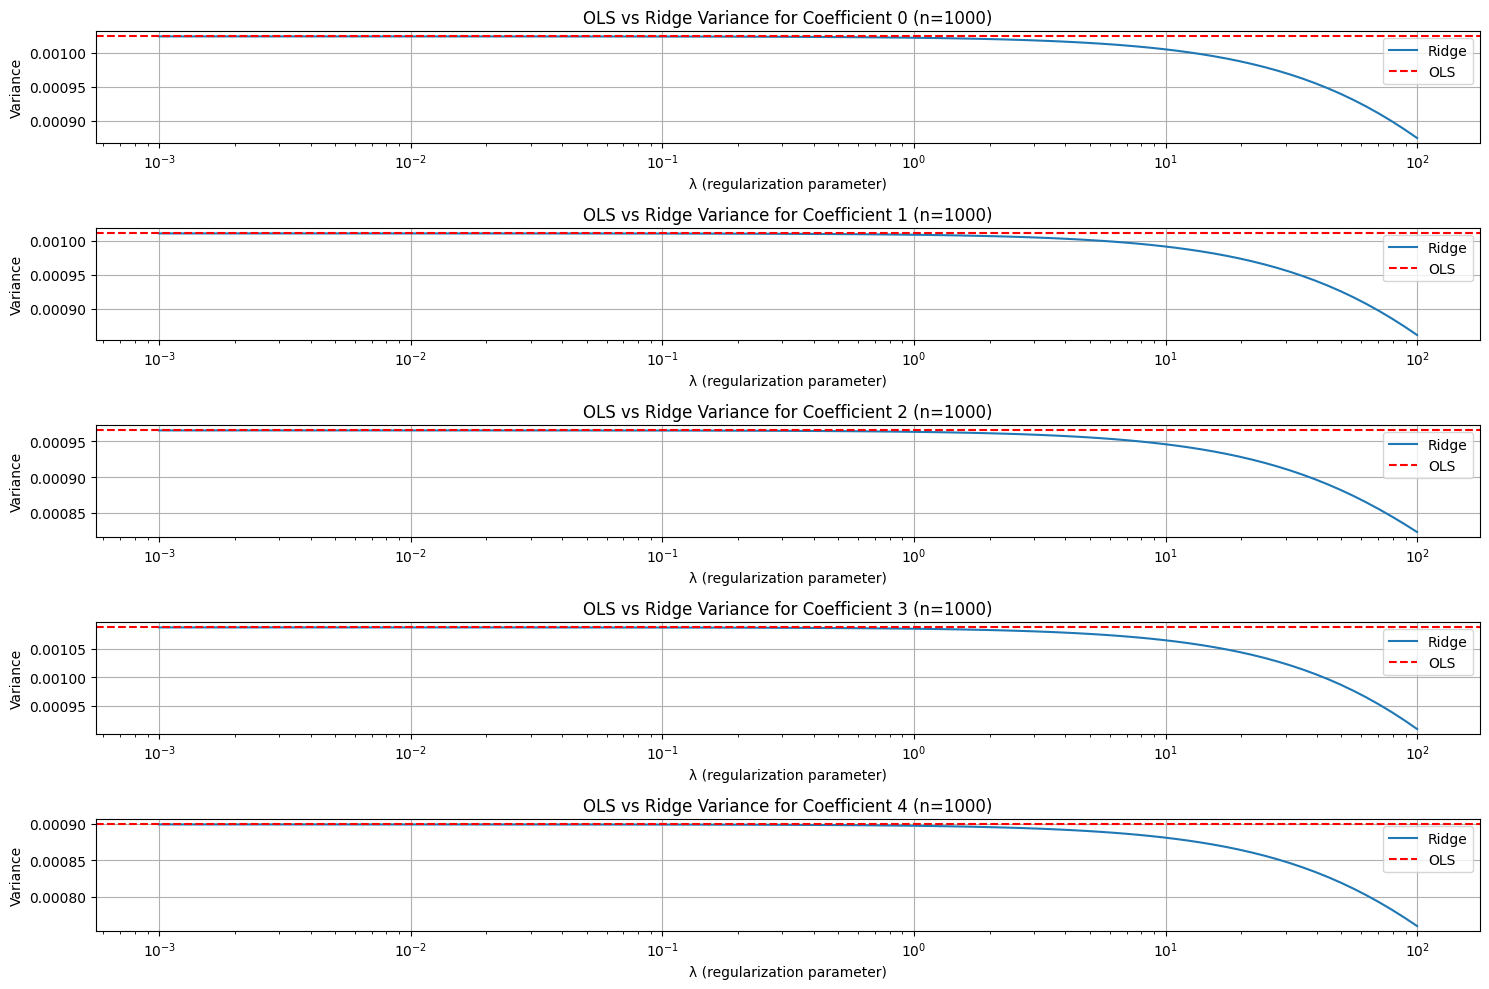

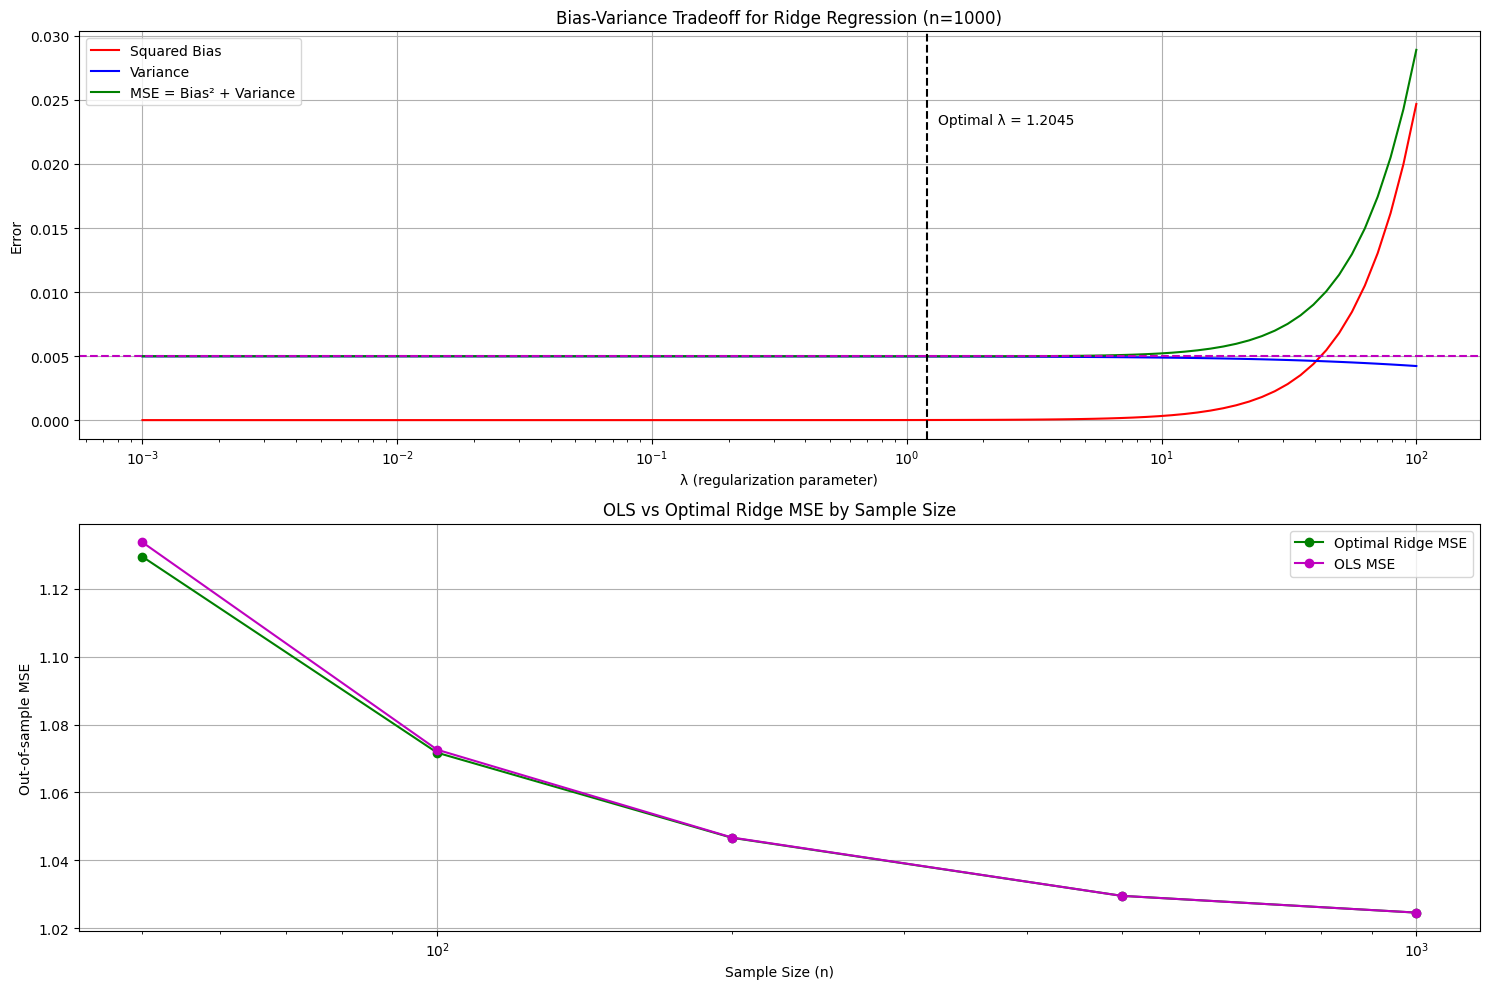

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)

# Hand implementation of OLS
def ols_estimator(X, y):
    """
    Ordinary Least Squares estimator.
    
    Args:
        X: Feature matrix of shape (n, p)
        y: Target vector of shape (n,)
    
    Returns:
        beta_hat: OLS coefficient estimates
    """
    # Calculate (X'X)^(-1)X'y
    XtX = X.T @ X
    XtX_inv = np.linalg.inv(XtX)
    Xty = X.T @ y
    beta_hat = XtX_inv @ Xty
    
    return beta_hat

# Hand implementation of Ridge Regression
def ridge_estimator(X, y, lambda_):
    """
    Ridge Regression estimator.
    
    Args:
        X: Feature matrix of shape (n, p)
        y: Target vector of shape (n,)
        lambda_: Regularization parameter
    
    Returns:
        beta_hat: Ridge coefficient estimates
    """
    n, p = X.shape
    # Calculate (X'X + λI)^(-1)X'y
    XtX = X.T @ X
    I = np.eye(p)
    XtX_ridge = XtX + lambda_ * I
    XtX_ridge_inv = np.linalg.inv(XtX_ridge)
    Xty = X.T @ y
    beta_hat = XtX_ridge_inv @ Xty
    
    return beta_hat

# Function to generate data from a linear DGP
def generate_linear_data(n, p, beta, sigma=1.0):
    """
    Generate data from a linear Data Generating Process: y = X * beta + epsilon
    
    Args:
        n: Number of samples
        p: Number of features
        beta: True coefficients
        sigma: Standard deviation of the error term
    
    Returns:
        X: Feature matrix of shape (n, p)
        y: Target vector of shape (n,)
    """
    # Generate X from standard normal distribution
    X = np.random.normal(0, 1, size=(n, p))
    
    # Generate error term
    epsilon = np.random.normal(0, sigma, size=n)
    
    # Generate y according to linear model
    y = X @ beta + epsilon
    
    return X, y

# Function to calculate mean squared error
def mean_squared_error(y_true, y_pred):
    """Calculate the mean squared error between true and predicted values."""
    return np.mean((y_true - y_pred) ** 2)

# Main function for linear DGP simulation
def linear_dgp_simulation():
    # Parameters
    p = 5  # Number of features
    sigma = 1.0  # Noise standard deviation
    num_simulations = 1000  # Number of Monte Carlo simulations
    sample_sizes = [50, 100, 200, 500, 1000]  # Different sample sizes
    lambdas = np.logspace(-3, 2, 100)  # Ridge regularization parameters
    
    # True coefficients
    true_beta = np.array([0.5, -0.8, 1.2, -0.3, 0.7])
    
    # Results containers
    ols_betas_all = {}
    ridge_betas_all = {}
    ols_in_sample_mse = {}
    ols_out_sample_mse = {}
    ridge_in_sample_mse = {}
    ridge_out_sample_mse = {}
    
    # Large test set for out-of-sample evaluation
    X_test_large, y_test_large = generate_linear_data(10000, p, true_beta, sigma)
    
    print("\nRunning Monte Carlo simulations for Linear DGP...")
    
    # For each sample size
    for n in sample_sizes:
        print(f"Processing sample size n = {n}")
        
        # Initialize containers for this sample size
        ols_betas = np.zeros((num_simulations, p))
        ridge_betas = {lam: np.zeros((num_simulations, p)) for lam in lambdas}
        
        ols_in_mse = np.zeros(num_simulations)
        ols_out_mse = np.zeros(num_simulations)
        ridge_in_mse = {lam: np.zeros(num_simulations) for lam in lambdas}
        ridge_out_mse = {lam: np.zeros(num_simulations) for lam in lambdas}
        
        # Run Monte Carlo simulations
        for sim in tqdm(range(num_simulations)):
            # Generate training data
            X_train, y_train = generate_linear_data(n, p, true_beta, sigma)
            
            # Fit OLS
            beta_hat_ols = ols_estimator(X_train, y_train)
            ols_betas[sim] = beta_hat_ols
            
            # Compute in-sample and out-of-sample MSE for OLS
            y_train_pred_ols = X_train @ beta_hat_ols
            y_test_pred_ols = X_test_large @ beta_hat_ols
            ols_in_mse[sim] = mean_squared_error(y_train, y_train_pred_ols)
            ols_out_mse[sim] = mean_squared_error(y_test_large, y_test_pred_ols)
            
            # Fit Ridge for different lambda values
            for lam in lambdas:
                beta_hat_ridge = ridge_estimator(X_train, y_train, lam)
                ridge_betas[lam][sim] = beta_hat_ridge
                
                # Compute in-sample and out-of-sample MSE for Ridge
                y_train_pred_ridge = X_train @ beta_hat_ridge
                y_test_pred_ridge = X_test_large @ beta_hat_ridge
                ridge_in_mse[lam][sim] = mean_squared_error(y_train, y_train_pred_ridge)
                ridge_out_mse[lam][sim] = mean_squared_error(y_test_large, y_test_pred_ridge)
        
        # Store results for this sample size
        ols_betas_all[n] = ols_betas
        ridge_betas_all[n] = ridge_betas
        ols_in_sample_mse[n] = ols_in_mse
        ols_out_sample_mse[n] = ols_out_mse
        ridge_in_sample_mse[n] = ridge_in_mse
        ridge_out_sample_mse[n] = ridge_out_mse
    
    # Analysis and plotting
    print("\nAnalysis of results:")
    
    # 1. Show that OLS is unbiased under this DGP
    plt.figure(figsize=(14, 8))
    for i, n in enumerate(sample_sizes):
        ols_bias = np.mean(ols_betas_all[n], axis=0) - true_beta
        plt.subplot(1, len(sample_sizes), i+1)
        plt.bar(range(p), ols_bias)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.title(f'OLS Bias with n={n}')
        plt.xlabel('Coefficient Index')
        plt.ylabel('Bias')
        plt.xticks(range(p))
        plt.grid(True)
    plt.tight_layout()
    plt.savefig('linear_dgp_ols_bias.png')
    
    # 2. Calculate variance of OLS coefficients
    ols_variance = {n: np.var(ols_betas_all[n], axis=0) for n in sample_sizes}
    
    plt.figure(figsize=(12, 6))
    for j in range(p):
        plt.plot([n for n in sample_sizes], [ols_variance[n][j] for n in sample_sizes], 
                marker='o', label=f'Coefficient {j}')
    plt.title('OLS Coefficient Variance vs. Sample Size')
    plt.xlabel('Sample Size (n)')
    plt.ylabel('Variance')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.savefig('linear_dgp_ols_variance_vs_n.png')
    
    # 3. Show in-sample and out-of-sample MSE for OLS with sample size
    plt.figure(figsize=(10, 6))
    plt.plot([n for n in sample_sizes], [np.mean(ols_in_sample_mse[n]) for n in sample_sizes], 
            'bo-', label='In-sample MSE')
    plt.plot([n for n in sample_sizes], [np.mean(ols_out_sample_mse[n]) for n in sample_sizes], 
            'ro-', label='Out-of-sample MSE')
    plt.xscale('log')
    plt.xlabel('Sample Size (n)')
    plt.ylabel('Mean Squared Error')
    plt.title('OLS MSE vs. Sample Size')
    plt.legend()
    plt.grid(True)
    plt.savefig('linear_dgp_ols_mse_vs_n.png')
    
    # 4. Show that Ridge is biased under this DGP
    plt.figure(figsize=(15, 10))
    n_reference = sample_sizes[-1]  # Use largest sample size for bias demonstration
    
    for j in range(p):
        plt.subplot(p, 1, j+1)
        ridge_bias = [np.mean(ridge_betas_all[n_reference][lam][:, j]) - true_beta[j] for lam in lambdas]
        plt.semilogx(lambdas, ridge_bias)
        plt.axhline(y=0, color='k', linestyle='--')
        plt.title(f'Ridge Regression Bias for Coefficient {j} (n={n_reference})')
        plt.xlabel('λ (regularization parameter)')
        plt.ylabel('Bias')
        plt.grid(True)
    plt.tight_layout()
    plt.savefig('linear_dgp_ridge_bias.png')
    
    # 5. Compare variance of OLS and Ridge
    plt.figure(figsize=(15, 10))
    n_reference = sample_sizes[-1]  # Use largest sample size for variance comparison
    
    for j in range(p):
        plt.subplot(p, 1, j+1)
        ridge_var = [np.var(ridge_betas_all[n_reference][lam][:, j]) for lam in lambdas]
        plt.semilogx(lambdas, ridge_var, label='Ridge')
        plt.axhline(y=ols_variance[n_reference][j], color='r', linestyle='--', label='OLS')
        plt.title(f'OLS vs Ridge Variance for Coefficient {j} (n={n_reference})')
        plt.xlabel('λ (regularization parameter)')
        plt.ylabel('Variance')
        plt.grid(True)
        plt.legend()
    plt.tight_layout()
    plt.savefig('linear_dgp_ols_vs_ridge_variance.png')
    
    # 6. Demonstrate MSE Decomposition for Ridge Regression
    plt.figure(figsize=(15, 10))
    n_reference = sample_sizes[-1]  # Use largest sample size for MSE decomposition
    
    # Calculate MSE components for each lambda
    ridge_bias_squared = np.zeros(len(lambdas))
    ridge_variance_sum = np.zeros(len(lambdas))
    
    for k, lam in enumerate(lambdas):
        # Compute squared bias for each coefficient and sum
        bias_vector = np.mean(ridge_betas_all[n_reference][lam], axis=0) - true_beta
        bias_squared = np.sum(bias_vector**2)
        
        # Compute variance for each coefficient and sum
        variance_vector = np.var(ridge_betas_all[n_reference][lam], axis=0)
        variance_sum = np.sum(variance_vector)
        
        ridge_bias_squared[k] = bias_squared
        ridge_variance_sum[k] = variance_sum
    
    # Calculate total MSE as bias^2 + variance
    ridge_mse = ridge_bias_squared + ridge_variance_sum
    
    # Plot the decomposition
    plt.subplot(2, 1, 1)
    plt.semilogx(lambdas, ridge_bias_squared, 'r-', label='Squared Bias')
    plt.semilogx(lambdas, ridge_variance_sum, 'b-', label='Variance')
    plt.semilogx(lambdas, ridge_mse, 'g-', label='MSE = Bias² + Variance')
    plt.title(f'Bias-Variance Tradeoff for Ridge Regression (n={n_reference})')
    plt.xlabel('λ (regularization parameter)')
    plt.ylabel('Error')
    plt.grid(True)
    plt.legend()
    
    # Mark the minimum MSE point
    min_mse_idx = np.argmin(ridge_mse)
    optimal_lambda = lambdas[min_mse_idx]
    plt.axvline(x=optimal_lambda, color='k', linestyle='--')
    plt.text(optimal_lambda*1.1, np.max(ridge_mse)*0.8, f'Optimal λ = {optimal_lambda:.4f}')
    
    # Compare Ridge with OLS MSE
    ols_bias_squared = 0  # OLS is unbiased
    ols_variance_sum = np.sum(ols_variance[n_reference])
    ols_mse = ols_bias_squared + ols_variance_sum
    
    plt.axhline(y=ols_mse, color='m', linestyle='--', label='OLS MSE')
    
    # 7. Compare MSE of Ridge and OLS as function of sample size
    plt.subplot(2, 1, 2)
    
    # For each sample size, find the optimal lambda and corresponding MSE
    optimal_ridge_mse = []
    optimal_lambdas = []
    
    for n in sample_sizes:
        # Compute mean out-of-sample MSE across simulations for each lambda
        mean_ridge_out_mse = [np.mean(ridge_out_sample_mse[n][lam]) for lam in lambdas]
        
        # Find the minimum MSE and corresponding lambda
        min_mse_idx = np.argmin(mean_ridge_out_mse)
        optimal_lambda = lambdas[min_mse_idx]
        optimal_ridge_mse.append(mean_ridge_out_mse[min_mse_idx])
        optimal_lambdas.append(optimal_lambda)
    
    # Plot optimal Ridge MSE vs OLS MSE
    plt.plot(sample_sizes, optimal_ridge_mse, 'go-', label='Optimal Ridge MSE')
    plt.plot(sample_sizes, [np.mean(ols_out_sample_mse[n]) for n in sample_sizes], 'mo-', label='OLS MSE')
    
    plt.title('OLS vs Optimal Ridge MSE by Sample Size')
    plt.xlabel('Sample Size (n)')
    plt.ylabel('Out-of-sample MSE')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()
    
    # Print the optimal lambda for each sample size
    print("\nOptimal λ values by sample size:")
    for i, n in enumerate(sample_sizes):
        print(f"n = {n}: λ = {optimal_lambdas[i]:.6f}")
    
    plt.tight_layout()
    plt.savefig('linear_dgp_bias_variance_tradeoff.png')
    
    # Return key results for reporting
    return {
        'sample_sizes': sample_sizes,
        'ols_bias': {n: np.mean(ols_betas_all[n], axis=0) - true_beta for n in sample_sizes},
        'ols_variance': ols_variance,
        'ridge_bias': {n: {lam: np.mean(ridge_betas_all[n][lam], axis=0) - true_beta 
                          for lam in [lambdas[0], lambdas[len(lambdas)//2], lambdas[-1]]} 
                      for n in [sample_sizes[0], sample_sizes[-1]]},
        'ols_mse': {n: np.mean(ols_out_sample_mse[n]) for n in sample_sizes},
        'optimal_ridge_mse': dict(zip(sample_sizes, optimal_ridge_mse)),
        'optimal_lambdas': dict(zip(sample_sizes, optimal_lambdas))
    }

if __name__ == "__main__":
    results = linear_dgp_simulation()
    print("\nSimulation complete. Check the generated plots for visualizations.")